In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Models/GDSC_PDX_TCGA_Second_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Models/GDSC_PDX_TCGA_Second_Strategy/Second_Strategy_Finetuned_Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
paclitaxel_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi/Paclitaxel/"
pathfindR_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/pathfindR/GDSC_PDX_TCGA_Second_Strategy/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
em_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Figures/GDSC_PDX_TCGA_Second_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC expression dataset (CYTOi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [5]:
# read GDSC expression dataset (CYTOi)

GDSCE = pd.read_csv("GDSC_exprs.z.CYTOi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
684055,1.3565140948247052,-0.277542411913307,0.0887087882196536,-0.2754829982302413,-0.5153856346587746,-0.6248712076433911,0.1243408990866293,-1.2699667684674136,2.0788360886382717,2.5197991997459197,...,-0.5571028630154293,-1.724090733574364,-0.3749080365068901,-0.0016055431935905,-0.3788535663547365,-1.3502092798315848,0.6949790577550328,0.4333032198982747,-0.1280986270308099,-1.629249958712223
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [6]:
# change directory to read GDSC CNA dataset (CYTOi)

os.chdir(dataset_dir + "/CNA/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA


In [7]:
# read GDSC CNA dataset (CYTOi)

GDSCC = pd.read_csv("GDSC_CNA.CYTOi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCC.drop_duplicates(keep='last')
GDSCC = pd.DataFrame.transpose(GDSCC)
GDSCC = GDSCC.loc[:, ~GDSCC.columns.duplicated()]

GDSCC.head()

gene_id,1,2,9,10,12,13,14,15,16,18,...,107133486,107133502,107133524,107161145,107985535,107986809,107987337,107987341,109731405,112441434
683665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,2.584963,0.000000,0.000000,0.000000,0.000000,0.00,1.807355,0.000000,0.000000
684055,0.000000,0.584963,0.584963,0.584963,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.584963,0.000000,0.584963,-4.32,-4.320000,0.000000,0.000000
684057,-0.415037,0.000000,0.584963,0.584963,-1.000000,0.000000,0.0,0.0,-0.415037,-0.415037,...,-0.415037,1.807355,-0.415037,0.000000,-0.415037,0.000000,-1.00,-1.000000,-0.415037,-0.415037
684059,0.000000,0.000000,0.000000,0.000000,0.000000,0.415037,0.0,0.0,0.000000,0.415037,...,0.415037,0.000000,-0.584963,0.000000,0.000000,0.000000,-4.32,-4.320000,0.000000,0.000000
684062,-0.415037,0.000000,0.321928,0.321928,-0.415037,-0.415037,0.0,0.0,-0.415037,0.000000,...,-0.415037,0.000000,-0.415037,0.000000,-0.415037,0.000000,-4.32,-4.320000,-0.415037,-1.000000


In [8]:
# change directory to read GDSC response dataset (CYTOi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [9]:
# read GDSC response dataset (CYTOi)

GDSCR = pd.read_csv("GDSC_response.CYTOi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])
GDSCR = GDSCR.loc[GDSCR["drug"] != "Paclitaxel", ]

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,1.27553797434562,GSK269962A,1,1,1
683665,0,-4.54428601391955,Vinorelbine,1,1,1
683665,0,1.72219893512551,PF-562271,1,1,1
683665,0,1.70736111120553,IPA-3,1,1,1
683665,0,-4.92424951856049,Epothilone B,1,1,1


In [10]:
# print count of cell lines for each drug (CYTOi)

GDSCR["drug"].value_counts()

drug
Vinorelbine     775
GSK429286A      771
Y-39983         769
Epothilone B    766
IPA-3           765
PF-562271       762
EHT 1864        761
Vinblastine     738
Docetaxel       738
GSK269962A      346
Name: count, dtype: int64

In [11]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (Paclitaxel)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [12]:
# read PDX expression dataset homogenized with GDSC expression dataset (Paclitaxel)

PDXEpaclitaxel = pd.read_csv("PDX_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEpaclitaxel = pd.DataFrame.transpose(PDXEpaclitaxel)
PDXEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1008,5.1683455924601,6.40148605928778,5.14735257900894,2.62182669498089,5.65801642244848,2.56126582112594,7.9002150761815,2.99037104024989,9.07138836072349,2.93107188443328,...,2.51273514040916,3.16885840754458,7.88710414124411,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,3.95569877310649,3.86826539821721,2.24540260166309
X-1156,5.64285976724198,6.16403060339034,6.56682953977831,2.62182669498089,2.20555612143949,2.68000643826337,8.28747895280708,2.40648953950849,6.85807798266578,3.44682372154383,...,2.6201404525098,3.05224139425924,6.43259864910441,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,5.32315076936616,3.85690425090814,2.27121625384186
X-1172,2.76326591576383,6.63737682195879,5.67675838505579,2.79473965144091,3.52596051559272,5.74258764261314,8.70184553811941,2.66283398075993,9.95397018105127,3.64884172474159,...,2.68566229198938,3.11779249946595,5.44497097056128,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,2.45399733779172,4.19271392722119,2.21127349569176


In [13]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Paclitaxel)

TCGAEpaclitaxel = pd.read_csv("TCGA_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEpaclitaxel = pd.DataFrame.transpose(TCGAEpaclitaxel)
TCGAEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-50-5068-01A,6.07077606939576,4.22435549873448,6.09703453175451,2.79409553041956,2.16511492655888,6.23897149546054,7.50971824388108,2.62136482478483,6.78739521681224,2.98021984531206,...,9.80444787373941,2.79886640790268,2.81581286530484,3.00085815257311,2.80511713535762,2.40148864399763,2.58029798170468,3.80309726320581,2.93775838077045,3.15136733303223
TCGA-53-7624-01A,3.36417856158271,1.84257380220382,4.89461611130517,3.01203072800212,1.08675483906125,2.65397613649159,8.19887134647799,2.64492131772784,9.57693655417731,2.75400746416671,...,9.87655475612095,2.79886640790268,2.81581286530484,3.47072364084828,2.92631228926461,3.04342978048926,3.85945702517433,2.76860237341666,4.70753879715127,4.40422733195751
TCGA-99-8033-01A,3.17759663469389,4.069358321802,5.30291306958158,3.04306111581331,1.71759129803103,2.9492322528108,8.35388516673678,2.61215713067395,9.55148283225251,2.62363654845594,...,9.97545462791267,2.79886640790268,2.81581286530484,3.61434933029633,2.82800183535407,2.62335146413649,2.82601101115657,2.76860237341666,4.83367880098437,4.96091320806586


In [14]:
# change directory to read PDX CNA dataset (Paclitaxel)

os.chdir(dataset_dir + "CNA")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA'

In [15]:
# read PDX CNA dataset (Paclitaxel)

PDXCpaclitaxel = pd.read_csv("PDX_CNA.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXCpaclitaxel.drop_duplicates(keep='last')
PDXCpaclitaxel = pd.DataFrame.transpose(PDXCpaclitaxel)
PDXCpaclitaxel = PDXCpaclitaxel.loc[:, ~PDXCpaclitaxel.columns.duplicated()]

PDXCpaclitaxel.head(3)

ENTREZID,1,2,3,9,10,12,13,14,15,16,...,101340252,102723547,102724473,103091865,105375355,107126285,109623460,109731405,118126072,128385369
X-1008,-0.3219280948873623,0.0,0.0,-1.6896598793878497,-1.6896598793878497,0.0,0.6182386555954547,-0.5145731728297583,0.0,-0.3400754415976217,...,0.3276873641760471,-0.3219280948873623,0.3785116232537298,0.0,-0.3129393116601076,0.0,-1.888968687611256,-0.3400754415976217,-0.7369655941662062,0.0
X-1156,0.9781956296816516,0.7004397181410922,0.7004397181410922,-0.2429767534925404,-0.2429767534925404,-0.2863041851566411,0.5607149544744789,0.3895668117627256,-0.2688167584278,-0.2688167584278,...,0.4594316186372972,0.0,-0.4246876693125631,-0.7369655941662062,0.0,1.100977647724821,-0.3770696490798233,-0.3219280948873623,-0.6551715030025588,0.0
X-1172,0.0,0.0,0.0,-0.5145731728297583,-0.5145731728297583,0.0,0.4276061727818994,0.4222330006830478,0.9297909977185974,0.0,...,-0.5994620704162712,-0.6780719051126377,0.3895668117627256,-0.4639470997597902,0.859969548221026,0.5109619192773793,-0.2863041851566411,0.0,0.0,1.0214797274104517


In [16]:
# read TCGA CNA dataset (Paclitaxel)

TCGACpaclitaxel = pd.read_csv("TCGA_CNA.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGACpaclitaxel.drop_duplicates(keep='last')
TCGACpaclitaxel = pd.DataFrame.transpose(TCGACpaclitaxel)
TCGACpaclitaxel = TCGACpaclitaxel.loc[:, ~TCGACpaclitaxel.columns.duplicated()]

TCGACpaclitaxel.head(3)

gene,1,2,3,9,10,11,12,13,14,15,...,100653016,100653017,100653018,100653019,100653020,100653021,100653022,100653023,100653024,100653025
TCGA-50-5068-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-53-7624-01A,1,0,0,-1,-1,-1,0,0,0,1,...,-1,1,1,-1,1,0,1,-1,-1,1
TCGA-99-8033-01A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# variance threshold for GDSC expression dataset (CYTOi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [18]:
# fill NA values and binarize GDSC CNA dataset (CYTOi)

GDSCC = GDSCC.fillna(0)
GDSCC[GDSCC != 0.0] = 1

In [19]:
# select shared genes between GDSC, PDX, and TCGA expression and CNA datasets 

ls = GDSCE.columns.intersection(GDSCC.columns)
ls = ls.intersection(PDXEpaclitaxel.columns)
ls = ls.intersection(PDXCpaclitaxel.columns)
ls = ls.intersection(TCGAEpaclitaxel.columns)
ls = ls.intersection(TCGACpaclitaxel.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 17839


In [20]:
# select shared samples between GDSC expression, CNA, and response datasets (CYTOi)

ls2 = GDSCE.index.intersection(GDSCC.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 800


In [21]:
# subset shared genes and samples in GDSC expression, CNA, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCC = GDSCC.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCC.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

# There exists same sample names for different drugs, so row shape is different in GDSC response data

GDSC # of common samples and genes (Expression): (800, 17839)
GDSC # of common samples and genes (CNA): (800, 17839)
GDSC # of samples (Response): 7191


In [22]:
# select shared samples between PDX expression and CNA datasets (Paclitaxel) 

ls3 = PDXEpaclitaxel.index.intersection(PDXCpaclitaxel.index)

print(f"PDX # of common samples (Paclitaxel): {ls3.shape[0]}")

PDX # of common samples (Paclitaxel): 43


In [23]:
# select shared samples between TCGA expression and CNA datasets (Paclitaxel) 

ls4 = TCGAEpaclitaxel.index.intersection(TCGACpaclitaxel.index)

print(f"TCGA # of common samples (Paclitaxel): {ls4.shape[0]}")

TCGA # of common samples (Paclitaxel): 35


In [24]:
# select shared genes and samples between PDX and TCGA expression and CNA datasets (Paclitaxel)

PDXEpaclitaxel = PDXEpaclitaxel.loc[ls3, ls]
PDXCpaclitaxel = PDXCpaclitaxel.loc[ls3, ls]

TCGAEpaclitaxel = TCGAEpaclitaxel.loc[ls4, ls]
TCGACpaclitaxel = TCGACpaclitaxel.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (Paclitaxel): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for CNA (Paclitaxel): {PDXCpaclitaxel.shape}\n")

print(f"TCGA # of common samples and genes for Expression (Paclitaxel): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for CNA (Paclitaxel): {TCGACpaclitaxel.shape}")

PDX # of common samples and genes for Expression (Paclitaxel): (43, 17839)
PDX # of common samples and genes for CNA (Paclitaxel): (43, 17839)

TCGA # of common samples and genes for Expression (Paclitaxel): (35, 17839)
TCGA # of common samples and genes for CNA (Paclitaxel): (35, 17839)


In [25]:
# change directory to read DEGs (CYTOi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi


In [26]:
# read DEGs (CYTOi)

DEGs_filtered_data = pd.read_excel("CYTOi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among cytoskeleton inhibitors\n")

DEGs_filtered_data.head()

There are 845 DEGs (p-adjusted < 0.05 and |logFC| > 1) among cytoskeleton inhibitors



,Gene Symbol,Frequency
0,PTGR1,8
1,SDC4,8
2,TPD52L1,8
3,S100A16,8
4,MYOF,8


In [27]:
# subset only DEGs with Frequency = 1

filter = DEGs_filtered_data["Frequency"] == 1
DEGs_freq_one =  DEGs_filtered_data[filter]
DEGs_freq_one.head()

,Gene Symbol,Frequency
498,CCR7,1
499,LTB,1
500,SP110,1
501,CD72,1
502,PSMB8,1


In [28]:
# read DEGs (Paclitaxel) and select paclitaxel-unique DEGs

DEGs_paclitaxel_data = pd.read_excel("CYTOi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                     sheet_name = "Paclitaxel")

filter = DEGs_paclitaxel_data["Gene.Symbol"].isin(DEGs_freq_one["Gene Symbol"])
only_paclitaxel_degs = DEGs_paclitaxel_data.loc[filter, "Gene.Symbol"]

print(f'There are {only_paclitaxel_degs.shape[0]} DEGs unique to Paclitaxel, so they were removed from the DEGs list')

There are 33 DEGs unique to Paclitaxel, so they were removed from the DEGs list


In [29]:
# remove paclitaxel-unique DEGs from feature set (CYTOi)

filter = DEGs_filtered_data["Gene Symbol"].isin(only_paclitaxel_degs)
DEGs_filtered_data = DEGs_filtered_data[~filter]

DEGs_filtered_data.head()

,Gene Symbol,Frequency
0,PTGR1,8
1,SDC4,8
2,TPD52L1,8
3,S100A16,8
4,MYOF,8


In [30]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CLECL1P', 2), ('CAST', 2)]
1 input query terms found no hit:	['SLC22A18']


812

In [31]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
cna = GDSCC
responses = GDSCR

In [32]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,1.27553797434562,GSK269962A,1,1,1
683665,0,-4.54428601391955,Vinorelbine,1,1,1
683665,0,1.72219893512551,PF-562271,1,1,1


In [33]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'Docetaxel',
 'EHT 1864',
 'Epothilone B',
 'GSK269962A',
 'GSK429286A',
 'IPA-3',
 'PF-562271',
 'Vinblastine',
 'Vinorelbine',
 'Y-39983'}

In [34]:
# convert Entrez gene IDs to string

GDSCE.index = GDSCE.index.astype(str)
GDSCC.index = GDSCC.index.astype(str)
responses.index = responses.index.astype(str)

In [35]:
# filter GDSC expression and CNA datasets (CYTOi) as to drugs
# subset selected DEGs

expression_zscores = []
CNA = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    expression_zscores.append(e_z)
    CNA.append(c)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCCv2 = GDSCCv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEpaclitaxel = PDXEpaclitaxel.loc[:,ls5]
PDXCpaclitaxel = PDXCpaclitaxel.loc[:,ls5]
TCGAEpaclitaxel = TCGAEpaclitaxel.loc[:,ls5]
TCGACpaclitaxel = TCGACpaclitaxel.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples and genes (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Paclitaxel (Expression): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Paclitaxel (CNA): {PDXCpaclitaxel.shape}\n")

print(f"TCGA # of common samples and genes for Paclitaxel (Expression): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Paclitaxel (CNA): {TCGACpaclitaxel.shape}")

GDSC # of common samples and genes (Expression): (7191, 801)
GDSC # of common samples and genes (CNA): (7191, 801)
GDSC # of common samples and genes (Response): 7191

PDX # of common samples and genes for Paclitaxel (Expression): (43, 801)
PDX # of common samples and genes for Paclitaxel (CNA): (43, 801)

TCGA # of common samples and genes for Paclitaxel (Expression): (35, 801)
TCGA # of common samples and genes for Paclitaxel (CNA): (35, 801)


In [36]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 1 0]


In [37]:
# change directory to read PDX and TCGA response datasets (Paclitaxel)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [38]:
# read PDX response dataset (Paclitaxel)

PDXRpaclitaxel = pd.read_csv("PDX_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRpaclitaxel.dropna(inplace=True)
PDXRpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRpaclitaxel["response"] = PDXRpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel_pdx = PDXRpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel_pdx.shape[0]} samples with response data in the PDX (Paclitaxel)\n")
Ytspaclitaxel_pdx

There are 43 samples with response data in the PDX (Paclitaxel)



array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [39]:
# read PDX dataset to select cohorts (Paclitaxel)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "paclitaxel",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-1004,BRCA
X-1008,BRCA
X-1156,NSCLC
X-1172,NSCLC
X-1189,NSCLC


In [40]:
# merged PDX cohort table with PDX response dataset (Paclitaxel)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRpaclitaxel,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
BRCA     24
NSCLC    19
Name: count, dtype: int64

In [41]:
# filter BRCA cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "BRCA")
pdx_brca_samples = dat_pdx.loc[filter,].index
pdx_brca_samples

Index(['X-1008', 'X-1298', 'X-1371', 'X-1383', 'X-1407', 'X-1468', 'X-1600',
       'X-1916', 'X-1921', 'X-2195', 'X-2344', 'X-2487', 'X-2524', 'X-2780',
       'X-3298', 'X-3450', 'X-3873', 'X-4347', 'X-4567', 'X-4824', 'X-4949',
       'X-5502', 'X-5975', 'X-6047'],
      dtype='object')

In [42]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_pdx_brca = PDXRpaclitaxel.loc[pdx_brca_samples,"response"].values
Ytspaclitaxel_pdx_brca

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0])

In [43]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

PDXRpaclitaxel.loc[pdx_brca_samples,"response"].value_counts()

response
0    19
1     5
Name: count, dtype: int64

In [44]:
# filter NSCLC cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1787',
       'X-1823', 'X-1834', 'X-1835', 'X-1934', 'X-1980', 'X-1993', 'X-2017',
       'X-2042', 'X-2082', 'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [45]:
# filter responses of NSCLC cohort samples (Paclitaxel)

Ytspaclitaxel_nsclc = PDXRpaclitaxel.loc[pdx_nsclc_samples,"response"].values
Ytspaclitaxel_nsclc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
# read TCGA response dataset (Paclitaxel)

TCGARpaclitaxel = pd.read_csv("TCGA_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARpaclitaxel.dropna(inplace=True)
TCGARpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARpaclitaxel["response"] = TCGARpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel_tcga = TCGARpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel_tcga.shape[0]} samples with response data in the TCGA (Paclitaxel)\n")
Ytspaclitaxel_tcga

There are 35 samples with response data in the TCGA (Paclitaxel)



array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [47]:
# TCGA cohort table with TCGA response dataset (Paclitaxel)

dat_tcga = TCGARpaclitaxel["cohort"]

dat_tcga.value_counts()

cohort
BRCA    27
LUAD     3
UCS      3
STAD     1
HNSC     1
Name: count, dtype: int64

In [48]:
# filter BRCA cohort samples (Paclitaxel)

filter = (TCGARpaclitaxel["cohort"] == "BRCA")
tcga_brca_samples = dat_tcga.loc[filter,].index
tcga_brca_samples

Index(['TCGA-A2-A0EP-01A', 'TCGA-A2-A3XS-01A', 'TCGA-A2-A3XW-01A',
       'TCGA-A2-A3XX-01A', 'TCGA-A2-A3XY-01A', 'TCGA-A2-A4S2-01A',
       'TCGA-A7-A4SA-01A', 'TCGA-A7-A4SE-01A', 'TCGA-A7-A5ZV-01A',
       'TCGA-A7-A5ZX-01A', 'TCGA-A8-A08X-01A', 'TCGA-A8-A09M-01A',
       'TCGA-AQ-A54O-01A', 'TCGA-B6-A402-01A', 'TCGA-D8-A3Z6-01A',
       'TCGA-EW-A1OY-01A', 'TCGA-EW-A1P3-01A', 'TCGA-EW-A2FR-01A',
       'TCGA-GM-A2DA-01A', 'TCGA-GM-A2DB-01A', 'TCGA-GM-A2DF-01A',
       'TCGA-GM-A2DH-01A', 'TCGA-GM-A2DM-01A', 'TCGA-GM-A2DN-01A',
       'TCGA-GM-A3XG-01A', 'TCGA-GM-A3XL-01A', 'TCGA-GM-A3XN-01A'],
      dtype='object', name='sample')

In [49]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_tcga_brca = TCGARpaclitaxel.loc[tcga_brca_samples,"response"].values
Ytspaclitaxel_tcga_brca

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1])

In [50]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

TCGARpaclitaxel.loc[tcga_brca_samples,"response"].value_counts()

response
1    22
0     5
Name: count, dtype: int64

In [51]:
# maximum iteration

max_iter = 50

In [52]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 128
hdm2 = 256
rate1 = 0.6
rate2 = 0.6
rate3 = 0.7

In [53]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEpaclitaxel_pdx = scalerGDSC.transform(PDXEpaclitaxel.values) 
X_testEpaclitaxel_pdx_brca = scalerGDSC.transform(PDXEpaclitaxel.loc[pdx_brca_samples,].values) 

X_testEpaclitaxel_tcga = scalerGDSC.transform(TCGAEpaclitaxel.values)    
X_testEpaclitaxel_tcga_brca = scalerGDSC.transform(TCGAEpaclitaxel.loc[tcga_brca_samples,].values)    

X_trainC = np.nan_to_num(GDSCCv2.values)
X_testCpaclitaxel_pdx = np.nan_to_num(PDXCpaclitaxel.values.astype(np.float32))
X_testCpaclitaxel_pdx_brca = np.nan_to_num(PDXCpaclitaxel.loc[pdx_brca_samples,].values.astype(np.float32))
X_testCpaclitaxel_tcga = np.nan_to_num(TCGACpaclitaxel.values)
X_testCpaclitaxel_tcga_brca = np.nan_to_num(TCGACpaclitaxel.loc[tcga_brca_samples,].values)

TX_testEpaclitaxel_pdx = torch.FloatTensor(X_testEpaclitaxel_pdx)
TX_testEpaclitaxel_pdx_brca = torch.FloatTensor(X_testEpaclitaxel_pdx_brca)

TX_testCpaclitaxel_pdx = torch.FloatTensor(X_testCpaclitaxel_pdx.astype(np.float32))
TX_testCpaclitaxel_pdx_brca = torch.FloatTensor(X_testCpaclitaxel_pdx_brca.astype(np.float32))

ty_testEpaclitaxel_pdx = torch.FloatTensor(Ytspaclitaxel_pdx.astype(int))

ty_testEpaclitaxel_pdx_brca = torch.FloatTensor(Ytspaclitaxel_pdx_brca.astype(int))

TX_testEpaclitaxel_tcga = torch.FloatTensor(X_testEpaclitaxel_tcga)
TX_testEpaclitaxel_tcga_brca = torch.FloatTensor(X_testEpaclitaxel_tcga_brca)

TX_testCpaclitaxel_tcga = torch.FloatTensor(X_testCpaclitaxel_tcga.astype(np.float32))
TX_testCpaclitaxel_tcga_brca = torch.FloatTensor(X_testCpaclitaxel_tcga_brca.astype(np.float32))

ty_testEpaclitaxel_tcga = torch.FloatTensor(Ytspaclitaxel_tcga.astype(int))
ty_testEpaclitaxel_tcga_brca = torch.FloatTensor(Ytspaclitaxel_tcga_brca.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampC, IC_dim = X_trainC.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output     

class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        self.EnC = torch.nn.Sequential(
            nn.Linear(IC_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnC(x)
        return output 
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy.pt")
AutoencoderC = torch.load(models_dir + "CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy.pt")

Clas = torch.load(models_dir + "Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy.pt")

AutoencoderE.eval()
AutoencoderC.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZCX = AutoencoderC(torch.FloatTensor(X_trainC))
ZTX = torch.cat((ZEX, ZCX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (CYTOi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (CYTOi): {round(AUCTaucpr,2)}\n")

ZETpaclitaxel_pdx = AutoencoderE(TX_testEpaclitaxel_pdx)
ZCTpaclitaxel_pdx = AutoencoderC(TX_testCpaclitaxel_pdx)
ZTTpaclitaxel_pdx = torch.cat((ZETpaclitaxel_pdx, ZCTpaclitaxel_pdx), 1)
ZTTpaclitaxel_pdx = F.normalize(ZTTpaclitaxel_pdx, p=2, dim=0)
PredTpaclitaxel_pdx = Clas(ZTTpaclitaxel_pdx)
AUCTpaclitaxel_pdx = roc_auc_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())
AUCTpaclitaxel_pdx_aucpr = average_precision_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())

ZETpaclitaxel_pdx_brca = AutoencoderE(TX_testEpaclitaxel_pdx_brca)
ZCTpaclitaxel_pdx_brca = AutoencoderC(TX_testCpaclitaxel_pdx_brca)
ZTTpaclitaxel_pdx_brca = torch.cat((ZETpaclitaxel_pdx_brca, ZCTpaclitaxel_pdx_brca), 1)
ZTTpaclitaxel_pdx_brca = F.normalize(ZTTpaclitaxel_pdx_brca, p=2, dim=0)
PredTpaclitaxel_pdx_brca = Clas(ZTTpaclitaxel_pdx_brca)
AUCTpaclitaxel_pdx_brca = roc_auc_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())
AUCTpaclitaxel_pdx_brca_aucpr = average_precision_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())

ZETpaclitaxel_tcga = AutoencoderE(TX_testEpaclitaxel_tcga)
ZCTpaclitaxel_tcga = AutoencoderC(TX_testCpaclitaxel_tcga)
ZTTpaclitaxel_tcga = torch.cat((ZETpaclitaxel_tcga, ZCTpaclitaxel_tcga), 1)
ZTTpaclitaxel_tcga = F.normalize(ZTTpaclitaxel_tcga, p=2, dim=0)
PredTpaclitaxel_tcga = Clas(ZTTpaclitaxel_tcga)
AUCTpaclitaxel_tcga = roc_auc_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
AUCTpaclitaxel_tcga_aucpr = average_precision_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())

ZETpaclitaxel_tcga_brca = AutoencoderE(TX_testEpaclitaxel_tcga_brca)
ZCTpaclitaxel_tcga_brca = AutoencoderC(TX_testCpaclitaxel_tcga_brca)
ZTTpaclitaxel_tcga_brca = torch.cat((ZETpaclitaxel_tcga_brca, ZCTpaclitaxel_tcga_brca), 1)
ZTTpaclitaxel_tcga_brca = F.normalize(ZTTpaclitaxel_tcga_brca, p=2, dim=0)
PredTpaclitaxel_tcga_brca = Clas(ZTTpaclitaxel_tcga_brca)
AUCTpaclitaxel_tcga_brca = roc_auc_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())
AUCTpaclitaxel_tcga_brca_aucpr = average_precision_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTpaclitaxel_pdx_finetuned = dict()
AUCTpaclitaxel_tcga_finetuned = dict()
AUCTpaclitaxel_pdx_brca_finetuned = dict()
AUCTpaclitaxel_tcga_brca_finetuned = dict()
AUCTpaclitaxel_pdx_aucpr_finetuned = dict()
AUCTpaclitaxel_tcga_aucpr_finetuned = dict()
AUCTpaclitaxel_pdx_brca_aucpr_finetuned = dict()
AUCTpaclitaxel_tcga_brca_aucpr_finetuned = dict()
for iter in range(max_iter):
    iter += 1  
    
    AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{iter}.pt")
    AutoencoderC_finetuned = torch.load(finetuned_dir + f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{iter}.pt")
    Clas_finetuned = torch.load(finetuned_dir + f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{iter}.pt")
   
    AutoencoderE_finetuned.eval()
    AutoencoderC_finetuned.eval()
    Clas_finetuned.eval()
      
    ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
    ZCX = AutoencoderC_finetuned(torch.FloatTensor(X_trainC))
    ZTX = torch.cat((ZEX, ZCX), 1)
    ZTX = F.normalize(ZTX, p=2, dim=0)
    PredX = Clas_finetuned(ZTX)
    AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
    AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
    ZETpaclitaxel_pdx = AutoencoderE_finetuned(TX_testEpaclitaxel_pdx)
    ZCTpaclitaxel_pdx = AutoencoderC_finetuned(TX_testCpaclitaxel_pdx)
    ZTTpaclitaxel_pdx = torch.cat((ZETpaclitaxel_pdx, ZCTpaclitaxel_pdx), 1)
    ZTTpaclitaxel_pdx = F.normalize(ZTTpaclitaxel_pdx, p=2, dim=0)
    PredTpaclitaxel_pdx = Clas_finetuned(ZTTpaclitaxel_pdx)
    AUCTpaclitaxel_pdx_finetuned[iter] = roc_auc_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())
    AUCTpaclitaxel_pdx_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_pdx.astype(int), PredTpaclitaxel_pdx.detach().numpy())

    ZETpaclitaxel_pdx_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_pdx_brca)
    ZCTpaclitaxel_pdx_brca = AutoencoderC_finetuned(TX_testCpaclitaxel_pdx_brca)
    ZTTpaclitaxel_pdx_brca = torch.cat((ZETpaclitaxel_pdx_brca, ZCTpaclitaxel_pdx_brca), 1)
    ZTTpaclitaxel_pdx_brca = F.normalize(ZTTpaclitaxel_pdx_brca, p=2, dim=0)
    PredTpaclitaxel_pdx_brca = Clas_finetuned(ZTTpaclitaxel_pdx_brca)
    AUCTpaclitaxel_pdx_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())
    AUCTpaclitaxel_pdx_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_pdx_brca.astype(int), PredTpaclitaxel_pdx_brca.detach().numpy())

    ZETpaclitaxel_tcga = AutoencoderE_finetuned(TX_testEpaclitaxel_tcga)
    ZCTpaclitaxel_tcga = AutoencoderC_finetuned(TX_testCpaclitaxel_tcga)
    ZTTpaclitaxel_tcga = torch.cat((ZETpaclitaxel_tcga, ZCTpaclitaxel_tcga), 1)
    ZTTpaclitaxel_tcga = F.normalize(ZTTpaclitaxel_tcga, p=2, dim=0)
    PredTpaclitaxel_tcga = Clas_finetuned(ZTTpaclitaxel_tcga)
    AUCTpaclitaxel_tcga_finetuned[iter] = roc_auc_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
    AUCTpaclitaxel_tcga_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_tcga.astype(int), PredTpaclitaxel_tcga.detach().numpy())
 
    ZETpaclitaxel_tcga_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_tcga_brca)
    ZCTpaclitaxel_tcga_brca = AutoencoderC_finetuned(TX_testCpaclitaxel_tcga_brca)
    ZTTpaclitaxel_tcga_brca = torch.cat((ZETpaclitaxel_tcga_brca, ZCTpaclitaxel_tcga_brca), 1)
    ZTTpaclitaxel_tcga_brca = F.normalize(ZTTpaclitaxel_tcga_brca, p=2, dim=0)
    PredTpaclitaxel_tcga_brca = Clas_finetuned(ZTTpaclitaxel_tcga_brca)
    AUCTpaclitaxel_tcga_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())
    AUCTpaclitaxel_tcga_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_tcga_brca.astype(int), PredTpaclitaxel_tcga_brca.detach().numpy())

max_key_pdx = max(AUCTpaclitaxel_pdx_aucpr_finetuned, key=AUCTpaclitaxel_pdx_aucpr_finetuned.get)
max_key_pdx_brca = max(AUCTpaclitaxel_pdx_brca_aucpr_finetuned, key=AUCTpaclitaxel_pdx_brca_aucpr_finetuned.get)
max_key_tcga = max(AUCTpaclitaxel_tcga_aucpr_finetuned, key=AUCTpaclitaxel_tcga_aucpr_finetuned.get)
max_key_tcga_brca = max(AUCTpaclitaxel_tcga_brca_aucpr_finetuned, key=AUCTpaclitaxel_tcga_brca_aucpr_finetuned.get)

print(f"GDSC - Training AUC (CYTOi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (CYTOi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel): {round(AUCTpaclitaxel_pdx,2)}")
print(f"PDX - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_pdx_aucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca,2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca_aucpr,2)}")
print(f"TCGA - Test AUC (Paclitaxel): {round(AUCTpaclitaxel_tcga,2)}")
print(f"TCGA - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca,2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca_aucpr,2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_pdx_brca],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_brca],2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_pdx_brca_finetuned[max_key_pdx_brca],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_pdx_brca_aucpr_finetuned[max_key_pdx_brca],2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_tcga_brca],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_brca],2)}")
print(f"TCGA - Test AUC (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_tcga_brca_finetuned[max_key_tcga_brca],2)}")
print(f"TCGA - Test AUCPR (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_tcga_brca_aucpr_finetuned[max_key_tcga_brca],2)}\n\n")

print("Models for maximum finetuning (Paclitaxel, PDX)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (Paclitaxel, PDX, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_pdx_brca}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_pdx_brca}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_pdx_brca}.pt")

print("\nModels for maximum finetuning (Paclitaxel, TCGA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (Paclitaxel, TCGA, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_tcga_brca}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_tcga_brca}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_TCGA_CYTOi_Expression_CNA_Second_Strategy_Finetuned_{max_key_tcga_brca}.pt")


GDSC - Training AUC (CYTOi): 0.77
GDSC - Training AUCPR (CYTOi): 0.32
PDX - Test AUC (Paclitaxel): 0.77
PDX - Test AUCPR (Paclitaxel): 0.29
PDX - Test AUC (Paclitaxel, BRCA): 0.67
PDX - Test AUCPR (Paclitaxel, BRCA): 0.41
TCGA - Test AUC (Paclitaxel): 0.55
TCGA - Test AUCPR (Paclitaxel): 0.78
TCGA - Test AUC (Paclitaxel, BRCA): 0.5
TCGA - Test AUCPR (Paclitaxel, BRCA): 0.86

GDSC - Training AUC (CYTOi, Finetuned): 0.78
GDSC - Training AUCPR (CYTOi, Finetuned): 0.33
PDX - Test AUC (Paclitaxel, Finetuned): 0.78
PDX - Test AUCPR (Paclitaxel, Finetuned): 0.34

GDSC - Training AUC (CYTOi, Finetuned): 0.77
GDSC - Training AUCPR (CYTOi, Finetuned): 0.32
PDX - Test AUC (Paclitaxel, BRCA, Finetuned): 0.75
PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): 0.61

GDSC - Training AUC (CYTOi, Finetuned): 0.78
GDSC - Training AUCPR (CYTOi, Finetuned): 0.32
TCGA - Test AUC (Paclitaxel, Finetuned): 0.62
TCGA - Test AUCPR (Paclitaxel, Finetuned): 0.82

GDSC - Training AUC (CYTOi, Finetuned): 0.78
GDSC - T

In [54]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=801, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [55]:
# show CNA layer parameters

AutoencoderC

AEC(
  (EnC): Sequential(
    (0): Linear(in_features=801, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [56]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=384, out_features=1, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Sigmoid()
  )
)

In [57]:
# create a dataframe with the prediction results 

ec = {"Data": ["Expr + CNA", "Expr + CNA (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTpaclitaxel_pdx,2), round(AUCTpaclitaxel_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTpaclitaxel_pdx_aucpr,2), round(AUCTpaclitaxel_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-BRCA)":  [round(AUCTpaclitaxel_pdx_brca,2), round(AUCTpaclitaxel_pdx_brca_finetuned[max_key_pdx_brca],2)],
       "AUCPR (PDX-BRCA)": [round(AUCTpaclitaxel_pdx_brca_aucpr,2), round(AUCTpaclitaxel_pdx_brca_aucpr_finetuned[max_key_pdx_brca],2)],
       "AUC (TCGA)": [round(AUCTpaclitaxel_tcga,2), round(AUCTpaclitaxel_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTpaclitaxel_tcga_aucpr,2), round(AUCTpaclitaxel_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-BRCA)":  [round(AUCTpaclitaxel_tcga_brca,2), round(AUCTpaclitaxel_tcga_brca_finetuned[max_key_tcga_brca],2)],
       "AUCPR (TCGA-BRCA)": [round(AUCTpaclitaxel_tcga_brca_aucpr,2), round(AUCTpaclitaxel_tcga_brca_aucpr_finetuned[max_key_tcga_brca],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

ec_dataframe = pd.DataFrame.from_dict(ec, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
ec_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_CNA_CYTOi_Paclitaxel_Second_Strategy.tsv",
                    sep = "\t",
                    index = False)


ec_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytspaclitaxel_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytspaclitaxel_pdx)) + ")",
    "AUC (PDX-BRCA)": "AUC (PDX-BRCA, N=" + str(len(Ytspaclitaxel_pdx_brca)) + ")",
    "AUCPR (PDX-BRCA)": "AUCPR (PDX-BRCA, N=" + str(len(Ytspaclitaxel_pdx_brca)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytspaclitaxel_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytspaclitaxel_tcga)) + ")",
    "AUC (TCGA-BRCA)": "AUC (TCGA-BRCA, N=" + str(len(Ytspaclitaxel_tcga_brca)) + ")",
    "AUCPR (TCGA-BRCA)": "AUCPR (TCGA-BRCA, N=" + str(len(Ytspaclitaxel_tcga_brca)) + ")"
    }, inplace = True
)

ec_dataframe

,Data,"AUC (GDSC, N=7191)","AUCPR (GDSC, N=7191)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)","AUC (TCGA, N=35)","AUCPR (TCGA, N=35)","AUC (TCGA-BRCA, N=27)","AUCPR (TCGA-BRCA, N=27)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + CNA,0.77,0.32,0.77,0.29,0.67,0.41,0.55,0.78,0.5,0.86,7191,801
1,Expr + CNA (Fine-tuned),0.78,0.33,0.78,0.34,0.75,0.61,0.62,0.82,0.66,0.92,7191,801


In [58]:
# merge all EM, EC, and EMC dataframes 

em_dataframe = pd.read_csv(em_dir + "GDSC_PDX_TCGA_Expression_Mutation_CYTOi_Paclitaxel_Second_Strategy.tsv",
                           sep = "\t")
em_dataframe.columns = ec_dataframe.columns

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_CYTOi_Paclitaxel_Second_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = ec_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=7191)","AUCPR (GDSC, N=7191)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)","AUC (TCGA, N=35)","AUCPR (TCGA, N=35)","AUC (TCGA-BRCA, N=27)","AUCPR (TCGA-BRCA, N=27)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,
Expr + Mut + CNA,0.78,0.32,0.35,0.1,0.35,0.19,0.56,0.76,0.55,0.86,7191,677
Expr + Mut + CNA (Fine-tuned),0.79,0.33,0.55,0.16,0.52,0.25,0.52,0.77,0.6,0.88,7191,677
Expr + CNA,0.77,0.32,0.77,0.29,0.67,0.41,0.55,0.78,0.5,0.86,7191,801
Expr + CNA (Fine-tuned),0.78,0.33,0.78,0.34,0.75,0.61,0.62,0.82,0.66,0.92,7191,801
Expr + Mut,0.79,0.33,0.42,0.12,0.51,0.28,0.43,0.68,0.51,0.87,7191,678
Expr + Mut (Fine-tuned),0.79,0.33,0.45,0.13,0.55,0.32,0.55,0.76,0.53,0.88,7191,678


In [59]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytspaclitaxel_pdx))})",
                               f"AUC (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})",
                               f"AUC (TCGA, N={str(len(Ytspaclitaxel_tcga))})",
                               f"AUC (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytspaclitaxel_pdx))})": f"PDX (N={str(len(Ytspaclitaxel_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})": f"PDX-BRCA (N={str(len(Ytspaclitaxel_pdx_brca))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytspaclitaxel_tcga))})": f"TCGA (N={str(len(Ytspaclitaxel_tcga))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel["response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel["response"].value_counts()[1]/sum(TCGARpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})": f"TCGA-BRCA (N={str(len(Ytspaclitaxel_tcga_brca))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=7191, p=801\nS=840, R=6351, S/N=0.12)","PDX (N=43, p=801\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=801\nS=5, R=19, S/N=0.21)","TCGA (N=35, p=801\nS=25, R=10, S/N=0.71)","TCGA-BRCA (N=27, p=801\nS=22, R=5, S/N=0.81)"
Data,,,,,
Expr + Mut + CNA,0.78,0.35,0.35,0.56,0.55
Expr + Mut + CNA (Fine-tuned),0.79,0.55,0.52,0.52,0.6
Expr + CNA,0.77,0.77,0.67,0.55,0.5
Expr + CNA (Fine-tuned),0.78,0.78,0.75,0.62,0.66
Expr + Mut,0.79,0.42,0.51,0.43,0.51
Expr + Mut (Fine-tuned),0.79,0.45,0.55,0.55,0.53


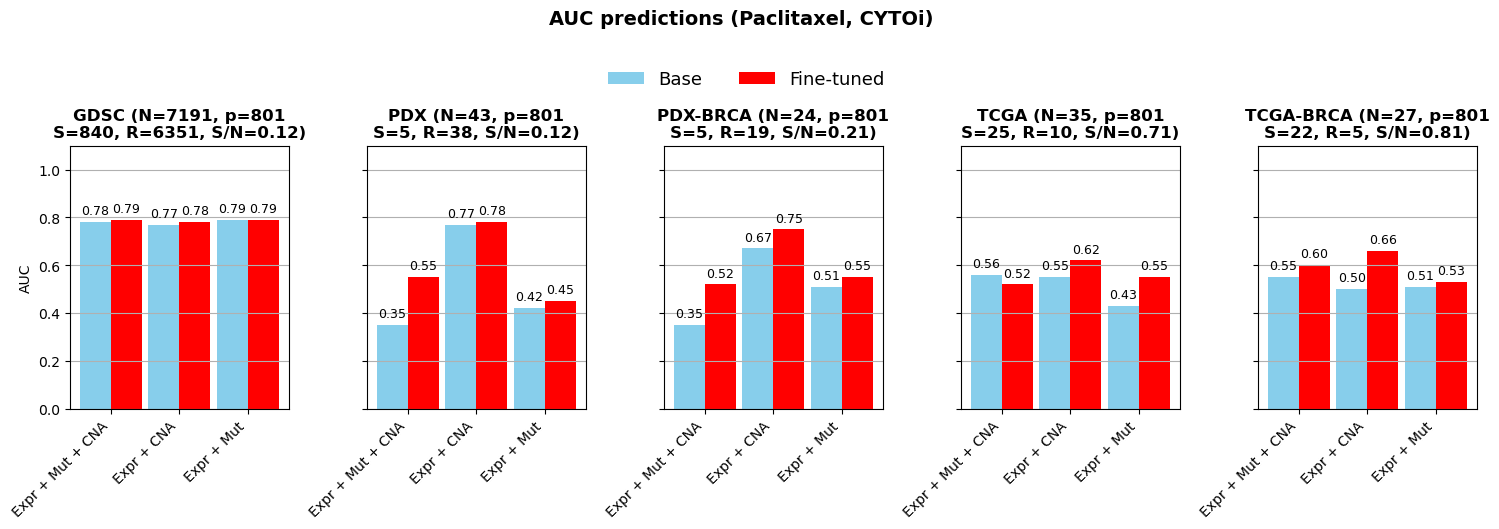

In [60]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Paclitaxel, CYTOi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + "AUC Plot (Paclitaxel, CYTOi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [61]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (PDX, N={str(len(Ytspaclitaxel_pdx))})",
                                 f"AUCPR (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})",
                                 f"AUCPR (TCGA, N={str(len(Ytspaclitaxel_tcga))})",
                                 f"AUCPR (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytspaclitaxel_pdx))})": f"PDX (N={str(len(Ytspaclitaxel_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-BRCA, N={str(len(Ytspaclitaxel_pdx_brca))})": f"PDX-BRCA (N={str(len(Ytspaclitaxel_pdx_brca))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytspaclitaxel_tcga))})": f"TCGA (N={str(len(Ytspaclitaxel_tcga))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel["response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel["response"].value_counts()[1]/sum(TCGARpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-BRCA, N={str(len(Ytspaclitaxel_tcga_brca))})": f"TCGA-BRCA (N={str(len(Ytspaclitaxel_tcga_brca))}, p=" + str(TCGAEpaclitaxel.shape[1]) + "\nS=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()[1]/sum(TCGARpaclitaxel.loc[TCGARpaclitaxel["cohort"] == "BRCA","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=7191, p=801\nS=840, R=6351, S/N=0.12)","PDX (N=43, p=801\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=801\nS=5, R=19, S/N=0.21)","TCGA (N=35, p=801\nS=25, R=10, S/N=0.71)","TCGA-BRCA (N=27, p=801\nS=22, R=5, S/N=0.81)"
Data,,,,,
Expr + Mut + CNA,0.32,0.1,0.19,0.76,0.86
Expr + Mut + CNA (Fine-tuned),0.33,0.16,0.25,0.77,0.88
Expr + CNA,0.32,0.29,0.41,0.78,0.86
Expr + CNA (Fine-tuned),0.33,0.34,0.61,0.82,0.92
Expr + Mut,0.33,0.12,0.28,0.68,0.87
Expr + Mut (Fine-tuned),0.33,0.13,0.32,0.76,0.88


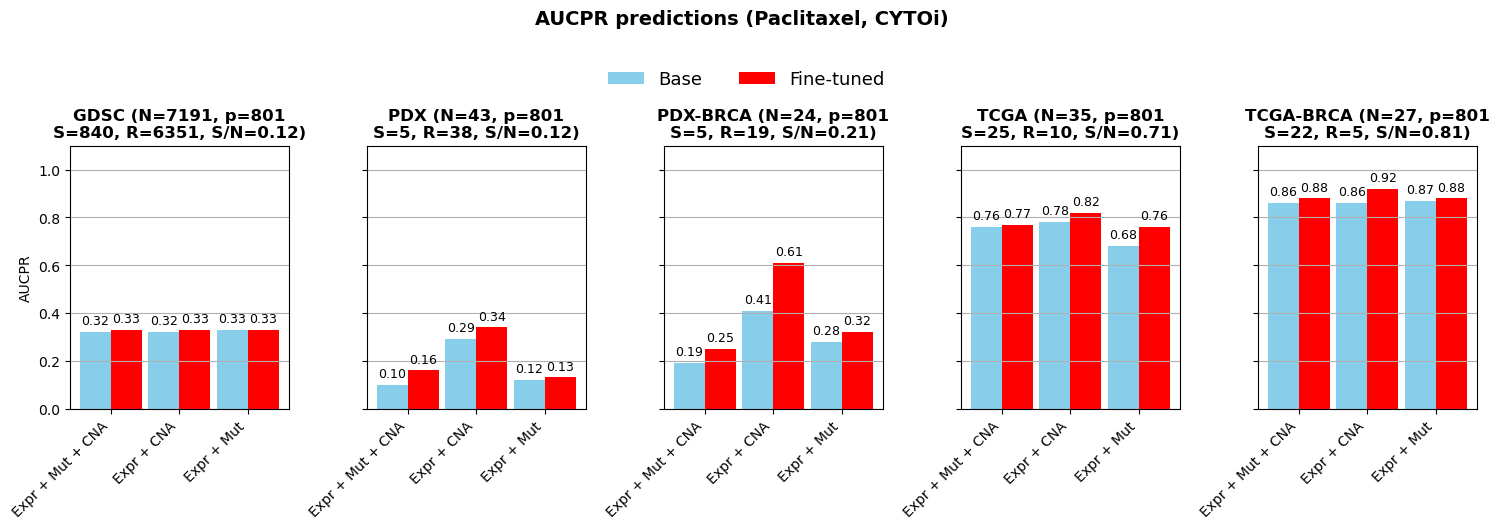

In [62]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Paclitaxel, CYTOi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Paclitaxel, CYTOi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [63]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/CYTOi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy


In [64]:
# save predictions

file = open('GDSC_PDX_TCGA_CYTOi_Paclitaxel_Predictions_Second_Strategy (Expression and CNA).txt', 'w')
file.write(f"GDSC Training (EC) AUC (CYTOi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EC) AUCPR (CYTOi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EC) AUC (Paclitaxel): {round(AUCTpaclitaxel_pdx,2)}\n")
file.write(f"PDX Test (EC) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EC) AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca,2)}\n")
file.write(f"PDX Test (EC) AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_pdx_brca_aucpr,2)}\n\n")

file.write(f"TCGA Test (EC) AUC (Paclitaxel): {round(AUCTpaclitaxel_tcga,2)}\n")
file.write(f"TCGA Test (EC) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EC) AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca,2)}\n")
file.write(f"TCGA Test (EC) AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_tcga_brca_aucpr,2)}\n")

file.close()

In [65]:
# get Gene symbols from Entrez ID

gene_list = mg.querymany(GDSCEv2.columns, 
                         species="human", 
                         scopes = "entrezgene",
                         field = "symbol",
                         as_dataframe=True)["symbol"]
gene_list

query
204801     NLRP11
118788    PIK3AP1
2059         EPS8
8204        NRIP1
10253       SPRY2
           ...   
51186      TCEAL9
4082       MARCKS
90102      PHLDB2
126969    SLC44A3
10235     RASGRP2
Name: symbol, Length: 801, dtype: object

In [66]:
# change directory to read DEG file (Paclitaxel)

os.chdir(paclitaxel_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi/Paclitaxel


In [67]:
# read DEG file (Paclitaxel)

paclitaxel_DEGs_data = pd.read_excel("Limma Results (EnsemblID).xlsx")
paclitaxel_DEGs_data = paclitaxel_DEGs_data.set_index('ID', drop=True)
paclitaxel_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
ID,,,,,,
ENSG00000088726,-1.268480,3.586764,-6.732562,6.381869e-11,6.685337e-07,14.205057
ENSG00000158023,-1.264376,3.490267,-6.709753,7.337251e-11,6.685337e-07,14.075779
ENSG00000158315,-1.153997,3.545926,-6.624056,1.235346e-10,7.503903e-07,13.593102
ENSG00000185650,-0.602372,3.685227,-6.183390,1.661383e-09,7.568847e-06,11.188236
ENSG00000019186,-1.493949,3.723812,-6.019371,4.220646e-09,1.538257e-05,10.326942


In [68]:
# get Gene symbols from Ensembl gene IDs

gene_symbols = mg.querymany(paclitaxel_DEGs_data.index, 
                              species="human", 
                              scopes = "ensembl.gene",
                              field = "symbol",
                              as_dataframe=True)["symbol"]

gene_symbols

1 input query terms found dup hits:	[('ENSG00000226506', 2)]
15 input query terms found no hit:	['ENSG00000291025', 'ENSG00000277796', 'ENSG00000176659', 'ENSG00000263574', 'ENSG00000168078', 'ENS


query
ENSG00000088726       TMEM40
ENSG00000158023      CFAP251
ENSG00000158315       RHBDL2
ENSG00000185650      ZFP36L1
ENSG00000019186      CYP24A1
                     ...    
ENSG00000108255       CRYBA1
ENSG00000147573       TRIM55
ENSG00000233746    LINC00656
ENSG00000181396       OGFOD3
ENSG00000168026       TTC21A
Name: symbol, Length: 18224, dtype: object

In [69]:
# merge Gene symbol column to the table

paclitaxel_merged_DEGs_data = pd.merge(paclitaxel_DEGs_data, pd.DataFrame(gene_symbols),  
                                       left_index=True, 
                                       right_index=True, 
                                       how='inner')

paclitaxel_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000088726,-1.268480,3.586764,-6.732562,6.381869e-11,6.685337e-07,14.205057,TMEM40
ENSG00000158023,-1.264376,3.490267,-6.709753,7.337251e-11,6.685337e-07,14.075779,CFAP251
ENSG00000158315,-1.153997,3.545926,-6.624056,1.235346e-10,7.503903e-07,13.593102,RHBDL2
ENSG00000185650,-0.602372,3.685227,-6.183390,1.661383e-09,7.568847e-06,11.188236,ZFP36L1
ENSG00000019186,-1.493949,3.723812,-6.019371,4.220646e-09,1.538257e-05,10.326942,CYP24A1


In [70]:
# subset DEGs in dataframe

filter = paclitaxel_merged_DEGs_data["symbol"].isin(gene_list)
paclitaxel_merged_DEGs_data = paclitaxel_merged_DEGs_data.loc[filter,:]

paclitaxel_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000158023,-1.264376,3.490267,-6.709753,7.337251e-11,6.685337e-07,14.075779,CFAP251
ENSG00000189280,-0.999167,3.304288,-5.891507,8.613615e-09,2.138124e-05,9.668560,GJB5
ENSG00000184292,-3.170620,4.453405,-5.891180,8.629205e-09,2.138124e-05,9.666892,TACSTD2
ENSG00000121316,-2.329463,4.803452,-5.875959,9.386483e-09,2.138124e-05,9.589294,PLBD1
ENSG00000138271,-1.705693,3.479670,-5.682340,2.696349e-08,5.459507e-05,8.616616,GPR87


In [91]:
# export table for pathfindR analysis

os.makedirs(pathfindR_dir, exist_ok = True)

paclitaxel_merged_DEGs_data.to_csv(pathfindR_dir + "GDSC_Expression_CNA_Filtered_DEGs_Table_CYTOi_Paclitaxel_Second_Strategy.tsv",
                                   index = False,
                                   sep = "\t")

In [92]:
# change directory to read GDSC response dataset (CYTOi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [93]:
# read GDSC response dataset but do not exclude paclitaxel (CYTOi)

GDSCR = pd.read_csv("GDSC_response.CYTOi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,1.27553797434562,GSK269962A,1,1,1
683665,0,-4.54428601391955,Vinorelbine,1,1,1
683665,0,1.72219893512551,PF-562271,1,1,1
683665,0,1.70736111120553,IPA-3,1,1,1


In [74]:
# GDSC response dataset

responses = GDSCR
responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,1.27553797434562,GSK269962A,1,1,1
683665,0,-4.54428601391955,Vinorelbine,1,1,1


In [75]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '1299050', '1299050', '1299050', '1299050', '1299050', '910941',
       '910941', '1659818', '1659818', '1659818'],
      dtype='object', name='sample_name', length=7561)

In [76]:
# filter GDSC expression and CNA datasets as to drugs
# filter selected DEGs

expression_zscores = []
CNA = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    expression_zscores.append(e_z)
    CNA.append(c)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCCv2 = GDSCCv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEpaclitaxel = PDXEpaclitaxel.loc[:,ls5]
PDXCpaclitaxel = PDXCpaclitaxel.loc[:,ls5]
TCGAEpaclitaxel = TCGAEpaclitaxel.loc[:,ls5]
TCGACpaclitaxel = TCGACpaclitaxel.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples and genes (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Paclitaxel (Expression): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Paclitaxel (CNA): {PDXCpaclitaxel.shape}\n")

print(f"TCGA # of common samples and genes for Paclitaxel (Expression): {TCGAEpaclitaxel.shape}")
print(f"TCGA # of common samples and genes for Paclitaxel (CNA): {TCGACpaclitaxel.shape}")

GDSC # of common samples and genes (Expression): (7191, 801)
GDSC # of common samples and genes (CNA): (7191, 801)
GDSC # of common samples and genes (Response): 7560

PDX # of common samples and genes for Paclitaxel (Expression): (43, 801)
PDX # of common samples and genes for Paclitaxel (CNA): (43, 801)

TCGA # of common samples and genes for Paclitaxel (Expression): (35, 801)
TCGA # of common samples and genes for Paclitaxel (CNA): (35, 801)


In [77]:
# subset sensitive and resistant cell lines in GDSC, PDX, and TCGA 

filter = (GDSCRv2["drug"] == "Paclitaxel")
paclitaxel_samples = GDSCRv2.loc[filter,:]

filter = (paclitaxel_samples["response"] == 0)
gdsc_paclitaxel_resistant_samples = paclitaxel_samples.loc[filter,:].index
gdsc_paclitaxel_sensitive_samples = paclitaxel_samples.loc[~filter,:].index

filter = (PDXRpaclitaxel["response"] == 0)
pdx_paclitaxel_resistant_samples = PDXRpaclitaxel.loc[filter,:].index
pdx_paclitaxel_sensitive_samples = PDXRpaclitaxel.loc[~filter,:].index

filter = (TCGARpaclitaxel["response"] == 0)
tcga_paclitaxel_resistant_samples = TCGARpaclitaxel.loc[filter,:].index
tcga_paclitaxel_sensitive_samples = TCGARpaclitaxel.loc[~filter,:].index

print(f"There are {gdsc_paclitaxel_sensitive_samples.shape[0]} paclitaxel sensitive cell lines in GDSC")
print(f"There are {gdsc_paclitaxel_resistant_samples.shape[0]} paclitaxel resistant cell lines in GDSC\n")

print(f"There are {pdx_paclitaxel_sensitive_samples.shape[0]} paclitaxel sensitive cell lines in PDX")
print(f"There are {pdx_paclitaxel_resistant_samples.shape[0]} paclitaxel resistant cell lines in PDX\n")

print(f"There are {tcga_paclitaxel_sensitive_samples.shape[0]} paclitaxel sensitive cell lines in TCGA")
print(f"There are {tcga_paclitaxel_resistant_samples.shape[0]} paclitaxel resistant cell lines in TCGA")

There are 26 paclitaxel sensitive cell lines in GDSC
There are 343 paclitaxel resistant cell lines in GDSC

There are 5 paclitaxel sensitive cell lines in PDX
There are 38 paclitaxel resistant cell lines in PDX

There are 25 paclitaxel sensitive cell lines in TCGA
There are 10 paclitaxel resistant cell lines in TCGA


In [78]:
paclitaxel_samples.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,-3.64728727366553,Paclitaxel,1,1,1
684055,0,-0.214086166599541,Paclitaxel,1,1,1
684057,0,0.0960911562819403,Paclitaxel,1,1,1


In [79]:
PDXRpaclitaxel.head(3)

,drug,response,ResponseCategory,Treatment,Treatment target,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,exprs,CNA,mutations
sample_name,,,,,,,,,,,,,,,
X-1008,Paclitaxel,1,PR,paclitaxel,Tubulin,single,-77.6,90,-44.7625,90,90.0,90,1,1,1
X-1156,Paclitaxel,0,PD,paclitaxel,Tubulin,single,395.4,21,83.9,14,7.573426573426573,31,1,1,1
X-1172,Paclitaxel,0,PD,paclitaxel,Tubulin,single,321.8,20,-14.525000000000006,11,14.845744680851064,20,1,1,1


In [80]:
TCGARpaclitaxel.head(3)

,patient,cohort,drug,response,measure_of_response,exprs_sample_barcode,cna_sample_barcode,mut_sample_barcode
sample,,,,,,,,
TCGA-50-5068-01A,TCGA-50-5068,LUAD,Paclitaxel,0,Clinical Progressive Disease,TCGA-50-5068-01A-01R-1628-07,TCGA-50-5068-01A-01D-1624-01,TCGA-50-5068-01A-01D-1625-08
TCGA-53-7624-01A,TCGA-53-7624,LUAD,Paclitaxel,0,Clinical Progressive Disease,TCGA-53-7624-01A-11R-2066-07,TCGA-53-7624-01A-11D-2062-01,TCGA-53-7624-01A-11D-2063-08
TCGA-99-8033-01A,TCGA-99-8033,LUAD,Paclitaxel,0,Stable Disease,TCGA-99-8033-01A-11R-2241-07,TCGA-99-8033-01A-11D-2237-01,TCGA-99-8033-01A-11D-2238-08


In [81]:
# export sensitive and resistant cell lines in GDSC for pathfindR analysis

gdsc_df = pd.DataFrame(paclitaxel_samples["response"])
gdsc_df = gdsc_df.reset_index()
gdsc_df.rename(columns = {"index": "Sample", "response": "Response"}, inplace = True)

gdsc_df.to_csv(pathfindR_dir + "GDSC Paclitaxel Samples.tsv",
               index = False,
               sep = "\t")

In [82]:
gdsc_df.head(3)

,Sample,Response
0,683665,0
1,684055,0
2,684057,0


In [83]:
# create and export experiment matrices for GDSC, PDX and TCGA for pathfindR analysis

filter = (GDSCE.index.isin(paclitaxel_samples.index))
gdsc_paclitaxel_df = GDSCE.loc[filter,:].transpose()

filter = (gdsc_paclitaxel_df.index.isin(GDSCEv2.columns))
gdsc_paclitaxel_exp_df = gdsc_paclitaxel_df.loc[filter,:]

gdsc_paclitaxel_exp_df.index = mg.querymany(gdsc_paclitaxel_exp_df.index,
                                            species="human",
                                            scopes = "entrezgene",
                                            field = "symbol",
                                            as_dataframe=True)["symbol"]

gdsc_paclitaxel_exp_df.to_csv(pathfindR_dir + "GDSC_Experiment_Matrix_CYTOi_Paclitaxel_Second_Strategy.tsv",
                              sep = "\t")

In [84]:
gdsc_paclitaxel_exp_df.head(3)

,683665,684055,684057,684059,684062,684072,684681,687448,687562,687568,...,1331025,1331032,1331034,1331035,1331037,1331038,1331039,1331040,1331049,1331050
symbol,,,,,,,,,,,,,,,,,,,,,
ACTA2,1.426463489204855,1.6856539151118584,0.4857884582330211,1.1027807357025692,0.6177880189059893,0.5418281742771544,1.3341658019135654,0.2265411418393919,0.2500931743121964,-0.4299764180084288,...,-0.8571987216610202,0.5349795402628312,-0.7800861459025892,-1.1038475635180585,-0.9636770316790734,-0.0849824421413235,0.6824763742610578,1.7550556394775343,0.6636965078549083,-0.7202281629587253
ACTN1,-1.3206711957875388,-1.103845226286596,-1.2699003831873168,-0.3717935179646573,-1.0097600785392011,-0.6945620392040204,0.6854015673688795,0.4637946433111208,0.6913626395969674,0.8283685389749245,...,-2.592590565041778,-1.961410846142744,-2.5343087339082824,-2.5216752559511866,-2.6504552871904408,-2.579621450781637,-2.461199903370572,-1.14628611769758,-1.9058959647054148,-2.5641564642554227
ADA,1.436681017298101,-0.0722572533106381,0.564012775113484,-0.0863264421063415,0.6177088620774955,0.514199291986227,0.4382670639153719,0.3397351927488285,0.2198526659041163,1.3993480389802648,...,1.261003842280518,2.195338715148727,-0.6935444277126762,0.2983156124449564,0.8534916059325343,0.058074654895683,-2.14365499909463,0.1709063991761442,1.1581424576938413,1.2323717569526946


In [85]:
# change directory to read DEG file (Paclitaxel)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi


In [86]:
# read DEG file (Paclitaxel)

paclitaxel_DEGs_filtered_data = pd.read_excel("CYTOi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                              sheet_name = "Paclitaxel")
paclitaxel_DEGs_filtered_data = paclitaxel_DEGs_filtered_data.loc[:,["Gene.Symbol","logFC","adj.P.Val"]]

paclitaxel_DEGs_filtered_data.head()

,Gene.Symbol,logFC,adj.P.Val
0,TMEM40,-1.268480,6.685337e-07
1,CFAP251,-1.264376,6.685337e-07
2,RHBDL2,-1.153997,7.503903e-07
3,CYP24A1,-1.493949,1.538257e-05
4,TACSTD2,-3.170620,2.138124e-05


In [87]:
# export frequency table of DEGs (Paclitaxel)
# these genes are unionized DEGs including ones found for paclitaxel. 
# There is no "Frequency = 1" in the table since  paclitaxel-unique DEGs were excluded

filter = DEGs_filtered_data["Gene Symbol"].isin(paclitaxel_DEGs_filtered_data["Gene.Symbol"])
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_Expression_CNA_DEGs_Freq_Table_CYTOi_Paclitaxel_Second_Strategy.tsv",
                                        index = False,
                                        sep = "\t")

In [88]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,PTGR1,8
1,SDC4,8
2,TPD52L1,8
3,S100A16,8
4,MYOF,8
...,...,...
464,LY6K,2
469,PAWR,2
474,BCAR3,2
494,STAP2,2


In [89]:
# export frequency table of DEGs (CYTOi)
# these genes are unionized DEGs for all cytoskeleton inhibitors

filter = DEGs_filtered_data["Gene Symbol"].isin(gene_list)
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_PDX_TCGA_Expression_CNA_DEGs_Freq_Table_CYTOi.tsv",
                                        index = False,
                                        sep = "\t")

In [90]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,PTGR1,8
1,SDC4,8
2,TPD52L1,8
3,S100A16,8
4,MYOF,8
...,...,...
840,BCAT1,1
841,P2RY10,1
842,ZHX2,1
843,ASPH,1
